# Bayesian Nonparamtric Quantile Regression 

## 1. Introduction

In this project I will provide a full implementation of Bayesian nonparametric quantile regression using Neural Net and asymmetric Laplace likelihood. Estimation is carried out using Hamilton Monte Carlo with Dual Averaging. The algorithm is tested using a simulation study and is applied on a real dataset. 

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import animation
from pandas import read_csv
from IPython.display import HTML

Let $Q_\tau(y|\mathbf{x}_i)$ denotes the conditional $\tau$ quantile of $y$ given the covariates $\mathbf{x}_i$. To estimate $Q_\tau(y|\mathbf{x}_i)$, I assume the data follows i.i.d asymmetric Laplace distribution with skewness $\tau$ and location modeled by a four layer neural network.
$$
y_i = g(\mathbf{x}_i) + \epsilon_i, \ i=1,\dots,n
$$
where
$$
f(\epsilon_i) = \frac{\tau(1-\tau)}{\sigma}\exp\left(-\frac{\epsilon_i(\tau-\mathbf{1}_{\epsilon_i<0})}{\sigma}\right)
$$
and
$$
g(\mathbf{x}_i) = \sum_{k=1}^K W^{(3)}_k\phi\left(\sum_{j=1}^JW_{j,k}^{(2)}\phi\left(\mathbf{W}^{(1)}_j\cdot\mathbf{x}_i+b^{(1)}_j\right)+b^{(2)}_k\right)+b^{(3)}
$$
I chose the activation function $\phi(\cdot)$ as the hyperbolic tangent function. 

In [2]:
def asymm_laplace (y, mu = 0, sigma = 1, tau = 0.5, log = False):
    """
    Asymmetric Laplace distribution
    """
    dens = tau * (1 - tau) / sigma * np.exp(-(y - mu) * (tau - (y < mu)) / sigma)
    if log:
        return(np.log(dens))
    else:
        return(dens)

def tanh (X, grad = False):
    """
    Hyperbolic tangent function
    """
    if grad:
        return 1-np.tanh(X)**2
    else:
        return np.tanh(X)
        

def forward (X, weight, bias):
    """
    Forward propagation
    """
    out = X @ weight + bias 
    
    return out

def neural_net (X, W_1, b_1, W_2, b_2, W_3, b_3):
    """
    Three layer feedforward neural network
    """
    W_1 = np.reshape(W_1, (1,J))
    W_2 = np.reshape(W_2, (J,K), 'F')
    W_3 = np.reshape(W_3, (K,1))
    hidden_one = tanh(forward(X, W_1, b_1))
    hidden_two = tanh(forward(hidden_one, W_2, b_2))
    output = forward(hidden_two, W_3, b_3)
    return output

Weight and bias parameters are given standard normal priors
$$
\mathbf{W}\sim N(0,1), \ \mathbf{b}\sim N(0,1)
$$
and estimation is carried out by Hamilton Monte Carlo with Dual Averaging (Hoffman & Gelman 2011).

In [3]:
def loglik (param, posterior = True):
    """
    Observed log-likelihood 
    """
    W_1 = param[0:J]
    b_1 = param[J:(2*J)]
    W_2 = param[(2*J):(2*J+J*K)]
    b_2 = param[(2*J+J*K):(2*J+J*K+K)]
    W_3 = param[(2*J+J*K+K):(2*J+J*K+2*K)]
    b_3 = param[2*J+J*K+2*K]
    nn = neural_net(X, W_1, b_1, W_2, b_2, W_3, b_3)
    diff = y - nn
    if posterior:
        loglik = np.sum(asymm_laplace(diff,0,sigma,tau,log = True)) + \
        np.sum(norm.logpdf(W_1)) + np.sum(norm.logpdf(b_1)) + \
        np.sum(norm.logpdf(W_2)) + np.sum(norm.logpdf(b_2)) + \
        np.sum(norm.logpdf(W_3)) + np.sum(norm.logpdf(b_3)) 
    else: 
        loglik = np.sum(asymm_laplace(diff,0,sigma,tau,log = True))
    return loglik


def loglik_grad (param):
    """
    Empirical gradient
    """
    W_1 = param[0:J]
    b_1 = param[J:(2*J)]
    W_2 = param[(2*J):(2*J+J*K)]
    b_2 = param[(2*J+J*K):(2*J+J*K+K)]
    W_3 = param[(2*J+J*K+K):(2*J+J*K+2*K)]
    b_3 = param[2*J+J*K+2*K]
    W_1 = np.reshape(W_1, (1,J))
    W_2 = np.reshape(W_2, (J,K), 'F')
    W_3 = np.reshape(W_3, (K,1))
    layer_one = forward(X, W_1, b_1)
    layer_two = forward(tanh(layer_one), W_2, b_2)
    nn = forward(tanh(layer_two), W_3, b_3)
    diff = y - nn
    grad_param = np.empty(len(param))
    grad_param[0:J] = 1/ sigma * np.sum((tau - (diff < 0)) * X * \
                                        tanh(layer_two,True) @ (W_3 * np.transpose(W_2)) * \
                                        tanh(layer_one,True),axis=0) - W_1
    grad_param[J:(2*J)] = 1 / sigma * np.sum((tau - (diff < 0)) * \
                                             tanh(layer_two,True) @ (W_3 * np.transpose(W_2)) * \
                                             tanh(layer_one,True),axis=0) - b_1
    grad_param[(2*J):(2*J+J*K)] = (1 / sigma * np.transpose(tanh(layer_one)) @ \
                                   ((tau-(diff<0)) * tanh(layer_two,True) * np.transpose(W_3)) - W_2).flatten(order='F')
    grad_param[(2*J+J*K):(2*J+J*K+K)] = 1 / sigma * np.reshape(W_3 * np.transpose(tanh(layer_two,True)) @ \
                                                               (tau - (diff < 0)),(K,)) - b_2
    grad_param[(2*J+J*K+K):(2*J+J*K+2*K)] = 1 / sigma * np.sum((tau - (diff < 0)) * \
                                                               tanh(layer_two),axis=0) - np.transpose(W_3)
    grad_param[2*J+J*K+2*K] = 1 / sigma * np.sum(tau - (diff < 0)) - b_3
    
    return grad_param
    
    
def find_start_ep (param):
    """
    Find a good starting value for the step size
    """
    q = param
    epsilon = epsilon_ = 0.01
    a_min = 0.25
    a_cross = 0.5
    a_max=  0.75
    d = 2.
    p = np.random.normal(size = len(q))
    current_E = loglik(q) - np.sum(p ** 2) / 2
    p = p + epsilon * loglik_grad(q) / 2
    q = q + epsilon * p
    p = p + epsilon * loglik_grad(q) / 2   
    proposed_E = loglik(q) - np.sum(p ** 2) / 2
    diff_E = proposed_E - current_E
    direction = 2 * (diff_E > np.log(a_cross)) - 1
    
    while direction*diff_E > direction * np.log(a_cross):
        epsilon = epsilon_
        epsilon_ = d ** direction * epsilon
        current_E = loglik(q) - np.sum(p ** 2) / 2
        p = p + epsilon_ * loglik_grad(q) / 2
        q = q + epsilon_ * p
        p = p + epsilon_ * loglik_grad(q) / 2   
        proposed_E = loglik(q) - np.sum(p ** 2) / 2     
        diff_E = proposed_E - current_E
        
    ep = np.sort((epsilon, epsilon_))
    epsilon, epsilon_ = ep
    counter = 0
    
    while ((diff_E > np.log(a_max)) | (diff_E < np.log(a_min))) & (counter < 100):
        
        epsilon_m = (epsilon + epsilon_) / 2
        current_E = loglik(q) - np.sum(p ** 2) / 2
        p = p + epsilon * loglik_grad(q) / 2
        q = q + epsilon * p
        p = p + epsilon * loglik_grad(q) / 2   
        proposed_E = loglik(q) - np.sum(p ** 2) / 2     
        diff_E = proposed_E - current_E
        
        if np.abs(diff_E) >= 1e5:
            epsilon = ep[0]
            break
        if diff_E > np.log(a_max):
            epsilon = epsilon_m
        elif diff_E < np.log(a_min):
            epsilon_ = epsilon_m
        else:
            epsilon = epsilon_m
            break
        counter += 1
    return epsilon
    
def hmc_samp (n_iter, n_adapt, inits, lam, delta):
    """
    Hamiltonian Monte Carlo sampler with leap frog integrator
    """
    print_step = np.int(n_iter/10)
    samps = np.empty((n_iter, len(inits)))
    log_ep = np.empty((n_iter,))
    lp_ = np.empty((n_iter,))
    log_ep_ = np.empty((n_adapt,))
    samps[0,] = inits
    lp_[0] = loglik(inits)
    log_ep[0] = np.log(find_start_ep(inits))
    mu = np.log(10*np.exp(log_ep[0]))
    H = 0
    gamma = 0.05
    t = 10
    kappa = 0.75
    for it in range(1,n_iter):
        current_q = samps[it-1,]
        epsilon = np.exp(log_ep[it-1])
        q = current_q
        p = np.random.normal(size = len(q))
        current_p = p
        n_step = np.minimum(500,np.int(np.maximum(1,np.round(lam/epsilon))))
        for l in range(0,n_step):
            p = p + epsilon * loglik_grad(q) / 2
            q = q + epsilon * p
            p = p + epsilon * loglik_grad(q) / 2
        p = -p
        current_E = loglik(current_q) - np.sum(current_p ** 2) / 2
        proposed_E = loglik(q) - np.sum(p ** 2) / 2
        diff_K = proposed_E - current_E
        alpha = np.exp(min(0,diff_K))
        if np.log(np.random.uniform()) < diff_K:
            current_q = q
        lp_[it] = loglik(current_q, False)
        samps[it,] = current_q
        if it <= n_adapt-1:
            H = (1 - 1 / (it + t)) * H + 1 / (it + t) * (delta - alpha)
            log_ep[it] = mu - np.sqrt(it) / gamma*H
            log_ep_[it] = it ** (-kappa) * log_ep[it] + (1 - it ** (-kappa)) * log_ep_[it-1]
        else:
            log_ep[it] = log_ep_[n_adapt-1]
        if (it + 1) % print_step == 0:
            print(it+1,"iterations completed.")
        if (it + 1) == n_iter:
            print("HMC sampling finished.")
    return samps, log_ep, lp_

def create_inits ():
    """
    Generate initial values
    """
    W_1 = np.random.normal(size = J)
    b_1 = np.random.normal(size = J)
    W_2 = np.random.normal(size = J*K)
    b_2 = np.random.normal(size = K)
    W_3 = np.random.normal(size = K)
    b_3 = np.random.normal(size = 1)
    inits = np.concatenate((W_1,b_1,W_2,b_2, W_3, b_3))
    inits = inits + np.random.uniform(-1,1,len(inits))
    return inits

## 2. Simulation

To see if my algorithm works correctly, I will perform a simulation study with data generated from
$$
X\sim U(-1,1), \ Q_{\tau}(y|X) = \frac{\Phi^{-1}(\tau)}{2}+5(\tau-0.5)X^2
$$
This data has strong heteroscedasticity, which is when inference using quantile regression is preferred. The 0.05, 0.1, ..., 0.95 quantiles are plotted below.

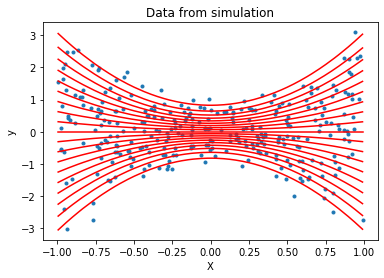

In [4]:
np.random.seed(591)
X = np.sort(np.random.uniform(-1,1,300))
tau_x = np.random.uniform(size = 300)
y = 0.5*norm.ppf(tau_x)+5*(tau_x-0.5)*X**2
plt.plot(X,y,'.')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Data from simulation')
for i in np.linspace(0.05,0.95,19):
    q = 0.5*norm.ppf(i)+5*(i-0.5)*X**2
    plt.plot(X,q,'r-')
plt.show()

My goal is to estimate the $0.9$ quantile. I will first normalize $X$ to $[0, 1]$ and $y$ to $[-1, 1]$. The standard deviation $\sigma$ in the asymmetric Laplace likelihood can be considered as a tuning parameter for the goodness of fit. Generally when there is no significant outliers $\sigma$ should be small. Here it is chosen to be $0.1$.

In [5]:
X = np.reshape(X,(len(X),1))
y = np.reshape(y,(len(y),1))

max_X = np.max(X)
min_X = np.min(X)
max_y = np.max(y)
min_y = np.min(y)

X_s = X
y_s = y

X = (X - min_X)/(max_X - min_X)
y = -1 + (y - min_y)*2/(max_y - min_y)

tau = 0.9

sigma = 0.1

For each hidden layer in the neural net, I put 10 hidden neurons.

In [6]:
J = 10

K = 10

Run Hamilton Monte Carlo with 200 iterations. The first 100 is used to tune adaptively the step size of leap frog integrator.

In [7]:
samps, log_ep, lp_ = hmc_samp(200,100,create_inits(),2,0.65)

20 iterations completed.
40 iterations completed.
60 iterations completed.
80 iterations completed.
100 iterations completed.
120 iterations completed.
140 iterations completed.
160 iterations completed.
180 iterations completed.
200 iterations completed.
HMC sampling finished.


Check convergence of likelihood.

[Text(0.5, 0, 'Iterations')]

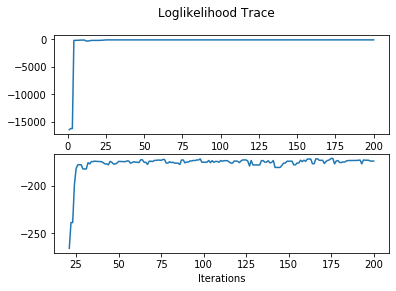

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Loglikelihood Trace')
axs[0].plot(range(1,201),lp_)
axs[1].plot(range(21,201),lp_[20:200])
axs[1].set(xlabel='Iterations')

Let's make an animation for the estimated 0.9 quantile of all iterations 

In [9]:
def init():
    plt.plot(X_s, y_s, 'k.')
    line.set_data([], [])
    return line,

def animate(i):
    plt_param = samps[i,]
    W_1 = plt_param[0:J]
    b_1 = plt_param[J:(2*J)]
    W_2 = plt_param[(2*J):(2*J+J*K)]
    b_2 = plt_param[(2*J+J*K):(2*J+J*K+K)]
    W_3 = plt_param[(2*J+J*K+K):(2*J+J*K+2*K)]
    b_3 = plt_param[2*J+J*K+2*K]
    nn = neural_net(X,W_1,b_1,W_2,b_2,W_3,b_3)
    q_plt = (nn+1)*(max_y-min_y)/2+min_y
    line.set_data(X_s, q_plt)
    return line,

In [10]:
%%capture
fig = plt.figure()
ax = plt.axes(xlim=(min_X, max_X), ylim=(min_y, max_y))
line, = ax.plot([], [])
plt.xlabel('X')
plt.ylabel('y')
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)
q_true = 0.5*norm.ppf(0.9)+5*(0.9-0.5)*X_s**2
plt.plot(X_s,q_true,'r-',label = "True")
plt.title("Convergence of estimated 0.9 quantile")
anim.save("591Sim.mp4")

![SegmentLocal](591Sim.gif "segment")

I will use the median of the last 100 iterations as my estimation.

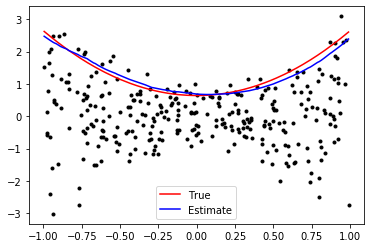

In [12]:
est_samp = samps[100:200,]
est_q = np.empty((100,len(X)))
for i in range(0,100):
    cur_param = est_samp[i,]
    W_1 = cur_param[0:J]
    b_1 = cur_param[J:(2*J)]
    W_2 = cur_param[(2*J):(2*J+J*K)]
    b_2 = cur_param[(2*J+J*K):(2*J+J*K+K)]
    W_3 = cur_param[(2*J+J*K+K):(2*J+J*K+2*K)]
    b_3 = cur_param[2*J+J*K+2*K]
    nn = neural_net(X,W_1,b_1,W_2,b_2,W_3,b_3)
    est_q[i,] = np.reshape((nn+1)*(max_y-min_y)/2+min_y,(len(X),))

est_q = np.median(est_q, axis = 0)

plt.plot(X_s,y_s,'k.')
plt.plot(X_s,q_true,'r-',label='True')
plt.plot(X_s,est_q,'b-',label='Estimate')
plt.legend()

## 3. Application

I applied my implementation on the motorcycle accident data (Silverman 1985).

In [13]:
motor = read_csv('motor.csv')
motor.head()

,times,accel
0,2.4,0.0
1,2.6,-1.3
2,3.2,-2.7
3,3.6,0.0
4,4.0,-2.7


Again X nad y are normalized to $[0,1]$ and $[-1,1]$ respectively.

In [14]:
X = np.array(motor['times'])
X = np.reshape(X,(len(X),1))
y = np.array(motor['accel'])
y = np.reshape(y,(len(y),1))

max_X = np.max(X)
min_X = np.min(X)
max_y = np.max(y)
min_y = np.min(y)

X_s = X
y_s = y

X = (X - min_X)/(max_X - min_X)
y = -1 + (y - min_y)*2/(max_y - min_y)

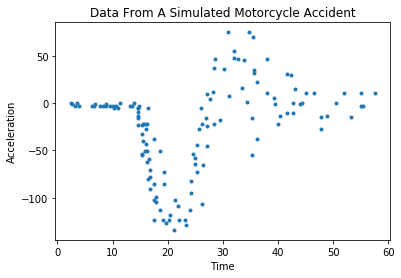

In [15]:
plt.plot('times', 'accel', '.', data = motor)
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Data From A Simulated Motorcycle Accident')
plt.show()

Let's estimate the 0.3 quantile this time. This is time I set $\sigma = 0.08$. Other specifications are unchanged.

In [16]:
tau = 0.3

sigma = 0.08

In [17]:
samps, log_ep, lp_ = hmc_samp(200,100,create_inits(),2,0.65)

20 iterations completed.
40 iterations completed.
60 iterations completed.
80 iterations completed.
100 iterations completed.
120 iterations completed.
140 iterations completed.
160 iterations completed.
180 iterations completed.
200 iterations completed.
HMC sampling finished.


Check convergence of likelihood.

[Text(0.5, 0, 'Iterations')]

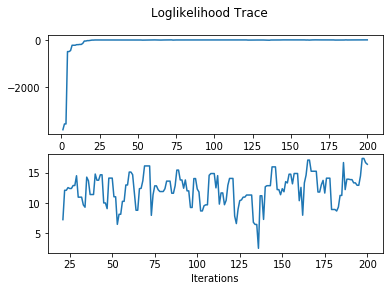

In [18]:
fig, axs = plt.subplots(2)
fig.suptitle('Loglikelihood Trace')
axs[0].plot(range(1,201),lp_)
axs[1].plot(range(21,201),lp_[20:200])
axs[1].set(xlabel='Iterations')

In [19]:
%%capture
fig = plt.figure()
ax = plt.axes(xlim=(min_X, max_X), ylim=(min_y, max_y))
line, = ax.plot([], [])
plt.xlabel('Time')
plt.ylabel('Acceleration')
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)
plt.title("Convergence of estimated 0.3 quantile")
anim.save("591App.mp4")

![SegmentLocal](591App.gif "segment")

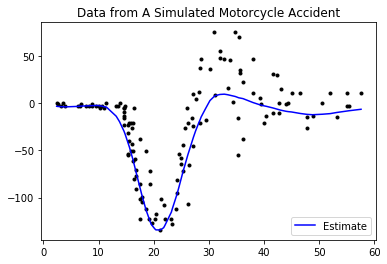

In [21]:
est_samp = samps[100:200,]
est_q = np.empty((100,len(X)))
for i in range(0,100):
    cur_param = est_samp[i,]
    W_1 = cur_param[0:J]
    b_1 = cur_param[J:(2*J)]
    W_2 = cur_param[(2*J):(2*J+J*K)]
    b_2 = cur_param[(2*J+J*K):(2*J+J*K+K)]
    W_3 = cur_param[(2*J+J*K+K):(2*J+J*K+2*K)]
    b_3 = cur_param[2*J+J*K+2*K]
    nn = neural_net(X,W_1,b_1,W_2,b_2,W_3,b_3)
    est_q[i,] = np.reshape((nn+1)*(max_y-min_y)/2+min_y,(len(X),))

est_q = np.median(est_q, axis = 0)
plt.plot(X_s,y_s,'k.')
plt.plot(X_s,est_q,'b-',label='Estimate')
plt.title('Data from A Simulated Motorcycle Accident')
plt.legend(loc = 'lower right')

## Reference

1. Hoffman, MD and Gelman, A (2014). “The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo.” *Journal of Machine Learning Research*, 15, 1593–1623.
2. Silverman, B. W. (1985) "Some aspects of the spline smoothing approach to non-parametric curve fitting." *Journal of the Royal Statistical Society series* B 47, 1–52.
3. Yu, K and Moyeed, R. A. (2001), “Bayesian quantile regression.” *Statistics & Probability Letters*, vol. 54, no. 4, pp. 437–447.